# About the project

TODO

# Libraries

In [1]:
import os, random, warnings, sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import product
from matplotlib.colors import ListedColormap

import sklearn
from sklearn import tree, metrics
from sklearn.metrics import classification_report, balanced_accuracy_score, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import LeaveOneOut, GridSearchCV, train_test_split
from sklearn.feature_selection import SelectFromModel

# Import custom libraries.
sys.path.append('Code/')
from utility import calculate_metrics, plot_performance, plot_performance_OD, plot_performance_OD_2, draw_sample, draw_subtraction_features, save_model
from dataset import load_and_preprocess, get_balance, downsampling, divide_dataset

### Plot and other settings

In [2]:
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['axes.spines.left'] = True
plt.rcParams['axes.spines.bottom'] = True
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.facecolor'] = 'white'

# Set seed for reproducibility
random.seed(123456)
np.random.seed(123456)

warnings.filterwarnings("ignore")

# Dataset loading and balancing analysis

In [3]:
X, y = load_and_preprocess()     # Dataset loading and preprocessing
y_OD = None                      # y for Outlier Detection
y_resampled = None               # y for Downsampling
resampled_dataframes = {}        # X resampled for each y_resampled

models = {
    'DT-FS': [[], [], [], [], [], [], []], # Decision Tree - Feature Selection
    'RF': [[], []],
}

Preprocessing...
  Null values of X:  0
  Null values of Y:  8 

  Columns of Y with null values:
    D-RIBose 
    D-SACcharose (sucrose) 
    potassium GlucoNaTe 
    potassium 2-KetoGluconate 
    potassium 5-KetoGluconate 

Dataset loaded and preprocessed!


## Balancing

Checking the balance of dataset classes is crucial. Unbalanced classes require specific treatments, particularly the need for balancing. The `get_balance` function enables us to examine the distribution of all classes throughout the dataset.

Two thresholds can be set:
 * A threshold beyond which it becomes more efficient to apply resampling techniques to balance the dataset.
 * A threshold beyond which it becomes more efficient to apply outlier detection techniques.
 
 
With the treshold for OD sets to 0.2 and the threshold for resampling sets to 0.4 it is possible to divide the various classes in three subsets based on the _positivity rate_:

 $$
    p = {positives \over negatives + positives}
 $$

 1. Set of classes to be predicted with OD:
 
 $$
    p \le 20\% \wedge p \ge 80\%
 $$


 2. Set of classes to be resampling before the training of a classic model;
 
 $$
    20\% \le p \le 40\% \wedge 60\% \le p \le 80\%
 $$

 3. Set of classes to be directly used to train a classic model.
 
 $$
    40\% \le p \le 60\%
 $$

In [4]:
threshold_rebalance = 0.4        # Under-sampling: 20%-40% or 60%-80% of majority class
threshold_OD = 0.2               # Outlier Detection: lower then 20% or greater than 80% of minority class
y_balanced = y.copy()
draw=False

balancing = get_balance(X, y, draw=draw, threshold_rebalance=threshold_rebalance, threshold_OD=threshold_OD)
y_balanced, y_od, y_resampled = divide_dataset(y_balanced, balancing, threshold_rebalance, threshold_OD)

### Downsampling

The resampling of the dataset was done via **undersampling**: being a biological dataset, oversampling was not suitable as non-existent bacteria could be introduced; some feature combinations may be **biologically impossible** or unrealistic due to restrictions imposed by the laws of chemistry and molecular biology.

For this reason, **undersampling** is more suitable.

In [5]:
resampled_dataframes = downsampling(X, y_resampled, threshold_rebalance, threshold_OD, draw=draw)

# Training

This code defines a function `train` that trains Random Forest classification models on various targets (carbohydrates) using the Leave-One-Out cross-validation method. The function can take a parameter grid (`param_grid`) for hyperparameter optimization or use predefined parameters (`params`). If the predefined parameters are not provided, it performs a search for the best parameters using GridSearchCV.

At the end of the algorithm, a DataFrame with the performance results and a dictionary with feature importance is returned.


In [32]:
def train(X, y, param_grid=None, params=None, misc=''):
    
    output = pd.DataFrame(columns=['Carbohydrates', 'Model', 'Estimators', 'Pos real', 'Pos pred', 'Precision', 'Recall', 'F1 score class 0', 'F1 score class 1', 'Micro', 'Macro', 'Balanced accuracy', 'Misc'])       
    output_tmp = []
            
    for carbohydrate in y.columns:

        y_col = y[carbohydrate]
        loo = LeaveOneOut()
        
        if params is not None:
            n_estimators = params.loc[carbohydrate, 'Estimators']

        else:            
            if param_grid is None:
                param_grid = { 'n_estimators': [32, 64, 128] }
                
            grid_search = GridSearchCV(estimator=RandomForestClassifier(), param_grid=param_grid, cv=loo, scoring='accuracy')
            grid_search.fit(X, y_col)
            best_params = grid_search.best_params_
        
        for i, (train_index, test_index) in enumerate(loo.split(X)):
            
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y_col.iloc[train_index], y_col.iloc[test_index]

            if params is not None:
                rfclf = RandomForestClassifier(n_estimators=n_estimators, max_depth=None, min_samples_split=2, random_state=1234, bootstrap=False)
            else:
                rfclf = RandomForestClassifier(**best_params)
                
            rfclf.fit(X_train, y_train)
            y_pred = rfclf.predict(X_test)
                
            models['RF'][0].extend(y_test)
            models['RF'][1].extend(y_pred.flatten())
                    
        if params is not None:
            new_row = calculate_metrics(models['RF'][0], models['RF'][1], carbohydrate_name=carbohydrate, model_name='RF', n_estimators=n_estimators, misc=misc)
        else:
            new_row = calculate_metrics(models['RF'][0], models['RF'][1], carbohydrate_name=carbohydrate, model_name='RF', n_estimators=best_params['n_estimators'], misc=misc)
            
        models['RF'][0] = []
        models['RF'][1] = []
    
        output_tmp.append(new_row)
        # display(new_row) 
            
    output = pd.concat(output_tmp, ignore_index=True)
        
        
    return output

## Classic train
We train the models for perfectly balanced classes.

In [34]:
params = None
param_grid = None

performance_classic = pd.DataFrame(columns=['Carbohydrates', 'Model', 'Estimators', 'Pos real', 'Pos pred', 'Precision', 'Recall', 'F1 score class 0', 'F1 score class 1', 'Micro', 'Macro', 'Balanced accuracy', 'Misc'])

if os.path.exists('./Result/Performance/performance_classic.xlsx'):
    params = pd.read_excel('./Result/Performance/performance_classic.xlsx').set_index('Carbohydrates')
else:  
    param_grid = {
        'n_estimators': [32, 64, 128]
    }
    
performance_classic = train(X, y_balanced, param_grid=param_grid, params=params, misc='Normal')
    
performance_classic = performance_classic.set_index('Carbohydrates')
display(performance_classic)

with pd.ExcelWriter('./Result/Performance/performance_classic.xlsx') as writer:
    performance_classic.to_excel(writer, index=True)

,Model,Estimators,Pos real,Pos pred,Precision,Recall,F1 score class 0,F1 score class 1,Micro,Macro,Balanced accuracy,Misc
Carbohydrates,,,,,,,,,,,,
D-RIBose,RF,32,250/509,230/509,0.778261,0.716000,0.773,0.746,0.760,0.760,0.759544,Normal
N-AcetylGlucosamine,RF,128,284/509,320/509,0.775000,0.873239,0.739,0.821,0.788,0.780,0.776620,Normal
SALicin,RF,64,236/509,199/509,0.783920,0.661017,0.789,0.717,0.758,0.753,0.751754,Normal
D-CELlobiose,RF,128,219/509,149/509,0.825503,0.561644,0.812,0.668,0.760,0.740,0.735994,Normal
D-LACtose (bovine origin),RF,32,212/509,182/509,0.785714,0.674528,0.827,0.726,0.788,0.776,0.771608,Normal
D-MELibiose,RF,128,205/509,172/509,0.790698,0.663415,0.836,0.721,0.794,0.779,0.772497,Normal
D-SACcharose (sucrose),RF,128,302/509,367/509,0.760218,0.923841,0.682,0.834,0.782,0.758,0.749360,Normal
D-TREhalose,RF,64,229/509,196/509,0.816327,0.698690,0.823,0.753,0.794,0.788,0.785059,Normal


## Train over resampled dataframe
We train the models for classes resampled using NCR.

,Model,Estimators,Pos real,Pos pred,Precision,Recall,F1 score class 0,F1 score class 1,Micro,Macro,Balanced accuracy,Misc
Carbohydrates,,,,,,,,,,,,
Methyl-αD-Glucopyranoside,RF,64,105/509,84/509,0.761905,0.609524,0.903,0.677,0.851,0.790,0.771867,Resampled
D-TURanose,RF,64,125/509,97/509,0.855670,0.664000,0.898,0.748,0.855,0.823,0.805180,Resampled
D-MANnitol,RF,128,134/509,99/509,0.939394,0.694030,0.915,0.798,0.880,0.856,0.835387,Resampled
AMYgdalin,RF,128,159/509,100/509,0.890000,0.559748,0.859,0.687,0.805,0.773,0.758473,Resampled
D-XYLose,RF,128,162/509,145/509,0.868966,0.777778,0.895,0.821,0.867,0.858,0.851339,Resampled
D-RAFfinose,RF,128,165/509,138/509,0.920290,0.769697,0.893,0.838,0.871,0.866,0.859386,Resampled
GENtiobiose,RF,128,183/509,186/509,0.811828,0.825137,0.798,0.818,0.809,0.808,0.807778,Resampled
L-ARAbinose,RF,64,189/509,172/509,0.906977,0.825397,0.891,0.864,0.879,0.878,0.875832,Resampled
ARButin,RF,128,195/509,196/509,0.811224,0.815385,0.805,0.813,0.809,0.809,0.809288,Resampled


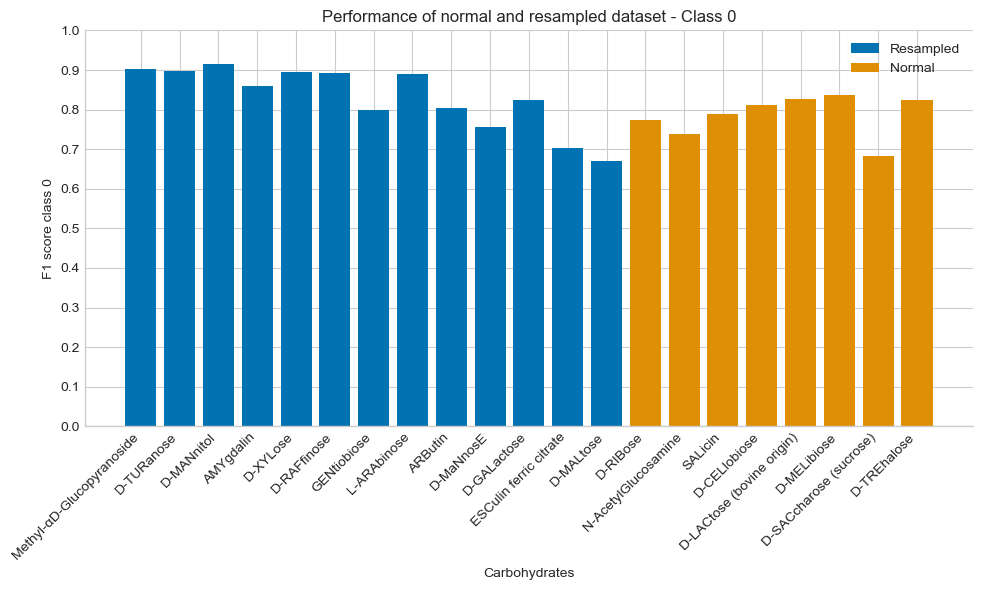

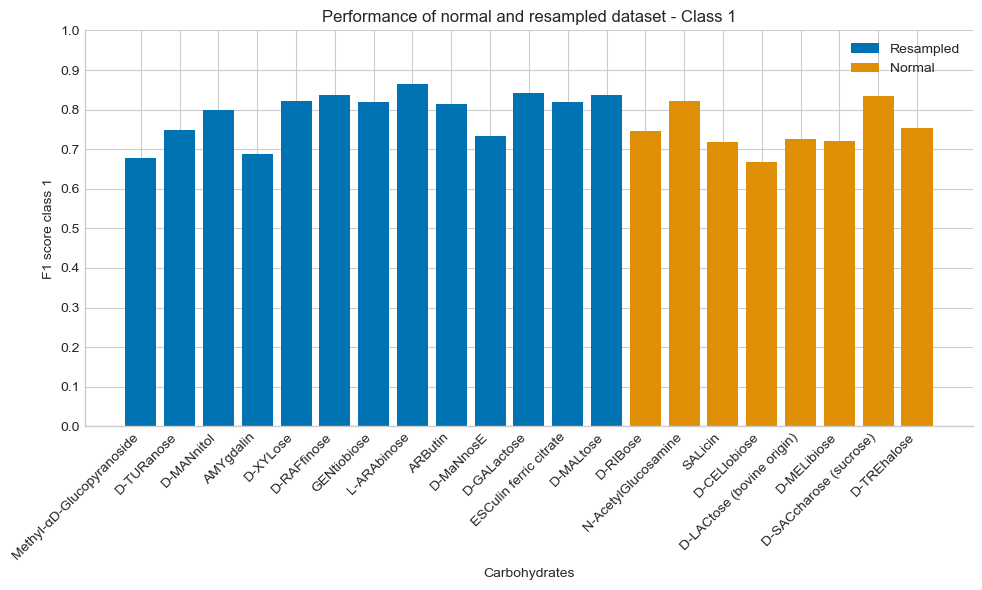

In [35]:
params = None
param_grid = None

if os.path.exists('./Result/Performance/performance_resampled.xlsx'):
    params = pd.read_excel('./Result/Performance/performance_resampled.xlsx').set_index('Carbohydrates')
    param_grid = None
else: 
    params = None
    param_grid = {
        'n_estimators': [16, 32, 64, 128]
    }

performance_resampled = pd.DataFrame(columns=['Carbohydrates', 'Model', 'Estimators', 'Pos real', 'Pos pred', 'Precision', 'Recall', 'F1 score class 0', 'F1 score class 1', 'Micro', 'Macro', 'Balanced accuracy', 'Misc'])

for carbohydrate, df in resampled_dataframes.items():
    
    y_col = df[carbohydrate].to_frame()
    df = df.drop(carbohydrate, axis=1)
    
    tmp = train(X=df, y=y_col, param_grid=param_grid, params=params, misc='Resampled')
    performance_resampled = pd.concat([performance_resampled, tmp], ignore_index=True)
        
performance_resampled = performance_resampled.set_index('Carbohydrates')
display(performance_resampled)

with pd.ExcelWriter('./Result/Performance/performance_resampled.xlsx') as writer:
    performance_resampled.to_excel(writer, index=True)
    

# General performance    
# plot_performance(pd.concat([performance_resampled, performance_classic]), file_name='performance_normal_class_0', metric='F1 score class 0', title='Performance of normal and resampled dataset - Class 0')
# plot_performance(pd.concat([performance_resampled, performance_classic]), file_name='performance_normal_class_1', metric='F1 score class 1', title='Performance of normal and resampled dataset - Class 1')

# Outlier Detection

## Feature Intersection

The function `feature_intersection` calculates the common features for a specified class. Sensitivity (`sensibility`) determines the threshold beyond which a feature is considered impactful. If `two_tail` is set to True, the function also considers features that are below a complementary threshold (1 - sensitivity). The function returns a DataFrame with the selected features, marking those that meet the specified criteria with 1.

__Note__: the minority class is always 1 because there is potentially an infinite variety of bacteria that test negative for a given test. This is why we refer to it as testing positive rather than testing negative.

In [13]:
def feature_intersection(X, y, sensibility=1, two_tail=False):
    """
    Calculates common features for the specified class.
    """

    if not (0 <= sensibility <= 1):
        raise ValueError("The parameter must be between 0 and 1.")

    out = pd.DataFrame(columns=X.columns)

    # For each feature, it checks how frequent it is and is evaluated as impactful (1) if greater than sensitivity
    selected_features = X.apply(lambda col: (col >= 1).sum() / len(X) >= sensibility).astype(int) 
    
    if two_tail:
        selected_features_2 = X.apply(lambda col: (col >= 1).sum() / len(X) <= 1-sensibility).astype(int) 
        selected_features = selected_features | selected_features_2 # Union.


    return selected_features

## Training

The function `train_OD` trains Decision Tree classification models with feature selection using the `feature_intersection` function. The various features are combined in six different methods, and the features from the method with the highest metrics are used. It employs Leave-One-Out cross-validation to evaluate the six models on each carbohydrate, excluding those specified.

In [14]:
def train_OD(X, y, negative_sensibility=0.55, positive_sensibility=0.75, k=50, best_params=None, draw=False):
        
    output = pd.DataFrame(columns=['Carbohydrates', 'Model', 'Estimators', 'Pos real', 'Pos pred', 'Precision', 'Recall', 'F1 score class 0', 'F1 score class 1', 'Micro', 'Macro', 'Balanced accuracy', 'Misc'])

    for carbohydrate in y.columns:
        
        if carbohydrate in excluded:
            continue
            
        if best_params is not None:
            negative_sensibility = best_params.loc[carbohydrate, 'negative_sensibility']
            positive_sensibility = best_params.loc[carbohydrate, 'positive_sensibility']
            k = best_params.loc[carbohydrate, 'k']
        
        models = {
            'DT-FS': [[], [], [], [], [], [], []],
        }

        y_col = y[carbohydrate]
        loo = LeaveOneOut()     
                    
        positive_X = X[y_col == 1]
        positive_y = y_col[y_col.index.isin(positive_X.index)]
        
        negative_X = X[y_col == 0]
        negative_y = y_col[y_col.index.isin(negative_X.index)]  
        
        np.random.seed(123456)
                        
        for i, (train_index, test_index) in enumerate(loo.split(positive_X)):

            X_train, X_test = positive_X.iloc[train_index], positive_X.iloc[test_index]
            y_train, y_test = positive_y.iloc[train_index], positive_y.iloc[test_index]
                       
            negative_indices = negative_X.index
            negative_index_to_add = np.random.choice(negative_indices)
            train_indices = negative_indices.drop(negative_index_to_add)
            test_indices = [negative_index_to_add]
            
            X_train_negative, y_train_negative = X.loc[train_indices], y[carbohydrate].loc[train_indices]
            X_test_negative, y_test_negative = X.loc[test_indices], y[carbohydrate].loc[test_indices]
            
            
            a = X_train.apply(lambda col: (col >= 1).sum())/len(X_train)
            b = X_train_negative.apply(lambda col: (col == 0).sum())/len(X_train_negative)
            
            # Features selection.
            negative_selected_features = feature_intersection(X_train_negative, y_train_negative, sensibility=negative_sensibility, two_tail=False)
            positive_selected_features_1 = feature_intersection(X_train, y_train)
            positive_selected_features_2 = feature_intersection(X_train, y_train, sensibility=positive_sensibility)
            positive_selected_features_3 = (positive_selected_features_2 - negative_selected_features).replace(-1, 0)
            positive_selected_features_4 = feature_intersection(positive_X, y_col, sensibility=positive_sensibility, two_tail=True)
            positive_selected_features_5 = (a/b).sort_values(ascending=False).index[:k]
            positive_selected_features_6 = (b/a).sort_values(ascending=False).index[:k]
                    
            if draw:                
                row_selected_features_5 = pd.Series([0] * len(X.columns), index=X.columns)
                row_selected_features_5.loc[positive_selected_features_5] = 1                
                row_selected_features_6 = pd.Series([0] * len(X.columns), index=X.columns)
                row_selected_features_6.loc[positive_selected_features_6] = 1
                
                draw_sample(X_train_negative, negative_selected_features, carbohydrate_name=f"{carbohydrate} - Negative class", index=0)
                draw_sample(X_train, positive_selected_features_1, carbohydrate_name=f"{carbohydrate} - method 1", index=i)
                draw_sample(X_train, positive_selected_features_2, carbohydrate_name=f"{carbohydrate} - method 2", index=i)
                draw_subtraction_features(positive_selected_features_2, negative_selected_features, positive_selected_features_3, carbohydrate_name=f"{carbohydrate} - method 3", index=i)
                draw_sample(X_train, positive_selected_features_3, carbohydrate_name=f"{carbohydrate} - method 3", index=i)   
                draw_sample(X_train, positive_selected_features_4, carbohydrate_name=f"{carbohydrate} - method 4", index=i)                
                draw_sample(X_train, row_selected_features_5, carbohydrate_name=f"{carbohydrate} - method 5", index=i)                
                draw_sample(X_train, row_selected_features_6, carbohydrate_name=f"{carbohydrate} - method 6", index=i)                

                
            X_train = pd.concat([X_train, X_train_negative], axis=0)
            y_train = pd.concat([y_train, y_train_negative], axis=0)           
            X_test = pd.concat([X_test, X_test_negative], axis=0)
            y_test = pd.concat([y_test, y_test_negative], axis=0)
            
            # Definitions, training and prediction.
            tree_1 = tree.DecisionTreeClassifier(max_depth=None, random_state=123456)
            tree_2 = tree.DecisionTreeClassifier(max_depth=None, random_state=123456)
            tree_3 = tree.DecisionTreeClassifier(max_depth=None, random_state=123456)
            tree_4 = tree.DecisionTreeClassifier(max_depth=None, random_state=123456)
            tree_5 = tree.DecisionTreeClassifier(max_depth=None, random_state=123456)
            tree_6 = tree.DecisionTreeClassifier(max_depth=None, random_state=123456)
                                    
            selected_columns_1 = X_train.columns[positive_selected_features_1 == 1]
            selected_columns_2 = X_train.columns[positive_selected_features_2 == 1]
            selected_columns_3 = X_train.columns[positive_selected_features_3 == 1]
            selected_columns_4 = X_train.columns[positive_selected_features_4 == 1]
            
            models['DT-FS'][0].extend(y_test)
            
            for tree_idx, (tree_model, selected_columns) in enumerate(
                [
                    (tree_1, selected_columns_1),
                    (tree_2, selected_columns_2),
                    (tree_3, selected_columns_3),
                    (tree_4, selected_columns_4),
                    (tree_5, positive_selected_features_5),
                    (tree_6, positive_selected_features_6),
                ]
            ):
                if len(selected_columns) == 0:
                    models['DT-FS'][tree_idx + 1].extend([0] * len(y_test))
                    continue

                tree_model.fit(X_train.loc[:, selected_columns], y_train)
                models['DT-FS'][tree_idx + 1].extend(tree_model.predict(X_test.loc[:, selected_columns]))


        for i in range(1,7):
            tmp = calculate_metrics(models['DT-FS'][0], models['DT-FS'][i], carbohydrate_name=carbohydrate, model_name='DT-FS', n_estimators=1, misc=f'Outlier Detection - FS{i}', n_sample=len(y[carbohydrate] == 1))
            tmp['negative_sensibility'] = negative_sensibility
            tmp['positive_sensibility'] = positive_sensibility
            tmp['k'] = k
            output = pd.concat([output, tmp], ignore_index=True)
        
    return output



def find_best_parameters(X, y, param_grid, draw=False):
    
    output = pd.DataFrame(columns=['Carbohydrates', 'Model', 'Estimators', 'Pos real', 'Pos pred', 'Precision', 'Recall', 'F1 score class 0', 'F1 score class 1', 'Micro', 'Macro', 'Balanced accuracy', 'Misc', 'negative_sensibility', 'positive_sensibility', 'k'])
    verbose_output = pd.DataFrame(columns=['Carbohydrates', 'Model', 'Estimators', 'Pos real', 'Pos pred', 'Precision', 'Recall', 'F1 score class 0', 'F1 score class 1', 'Micro', 'Macro', 'Balanced accuracy', 'Misc', 'negative_sensibility', 'positive_sensibility', 'k'])
    
    param_combinations = list(product(*param_grid.values()))
    
    print(f"\nNumber of combinations: {len(param_combinations)}")
    print("Computing combination -> ", end=' ')
    i = 1

    for params in param_combinations:
        neg_sensibility, pos_sensibility, k = params
    
        print(i, end=', ')
        i = i + 1

        performance = train_OD(X, y, negative_sensibility=neg_sensibility, positive_sensibility=pos_sensibility, k=k, draw=draw)
        
        verbose_output = pd.concat([output, performance])
        
        performance = performance.sort_values(by=['Carbohydrates', 'F1 score class 1', 'F1 score class 0', 'Balanced accuracy', 'Misc'], ascending=[True, False, False, False, True], axis=0)
        indices = range(0, len(performance), len(performance['Misc'].unique()))
        performance = performance.iloc[indices]  
        
        output = pd.concat([output, performance])
            
    output = output.sort_values(by=['Carbohydrates', 'F1 score class 1', 'F1 score class 0', 'Balanced accuracy', 'Misc'], ascending=[True, False, False, False, True], axis=0)
    
    # Takes the first row of each ordered group.
    indices = range(0, len(output), len(param_combinations))
    
    return output.iloc[indices], output


Number of combinations: 6
Computing combination ->  1, 2, 3, 4, 5, 6, 

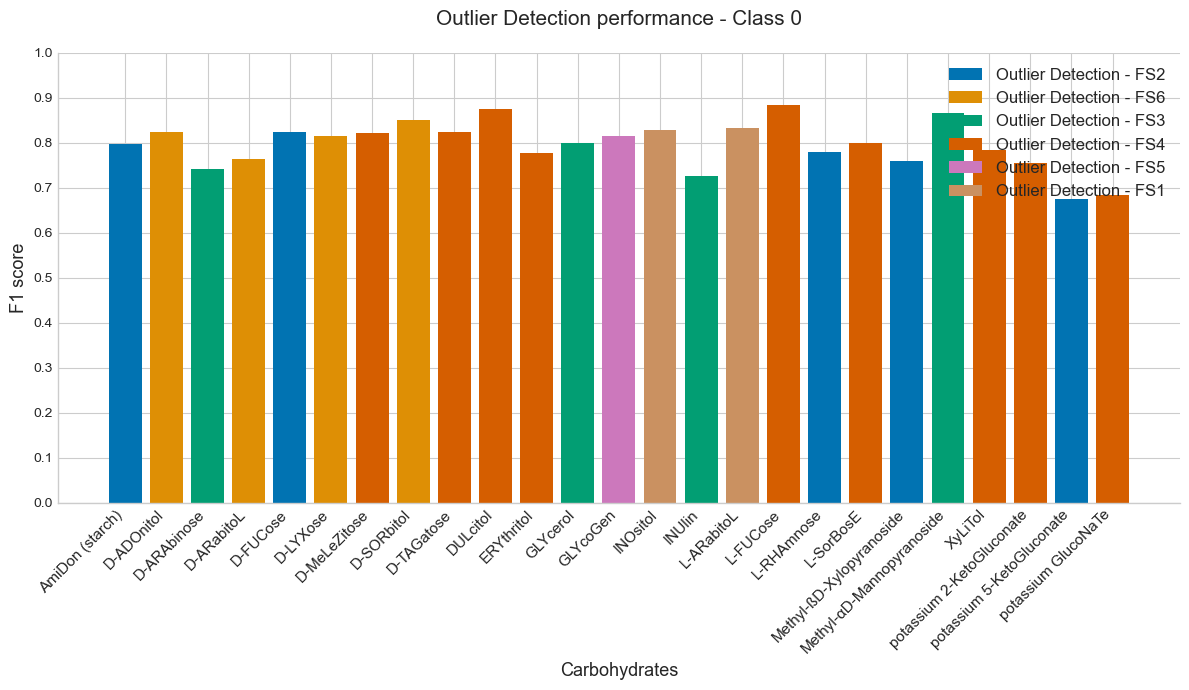

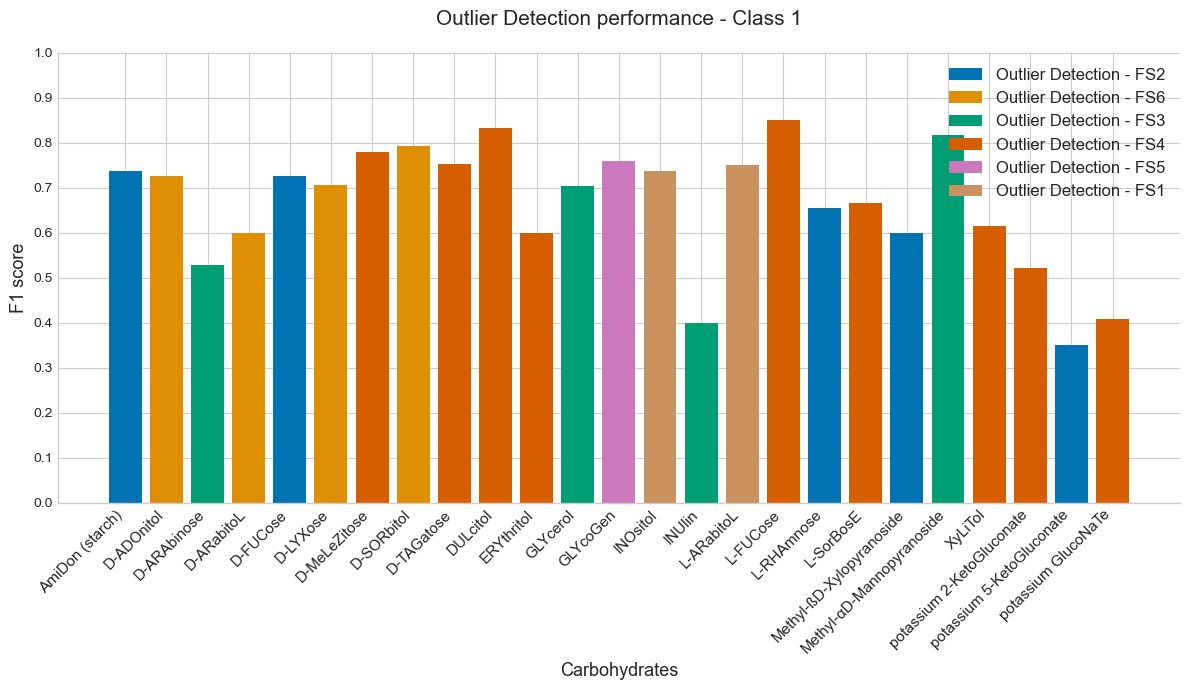

,Model,Estimators,Pos real,Pos pred,Precision,Recall,F1 score class 0,F1 score class 1,Micro,Macro,Balanced accuracy,Misc,negative_sensibility,positive_sensibility,k
Carbohydrates,,,,,,,,,,,,,,,
AmiDon (starch),DT-FS,1,81/509,60/509,0.866667,0.641975,0.798,0.738,0.772,0.768,0.771605,Outlier Detection - FS2,0.5,0.65,35.0
D-ADOnitol,DT-FS,1,7/509,4/509,1.000000,0.571429,0.824,0.727,0.786,0.775,0.785714,Outlier Detection - FS6,0.5,0.65,35.0
D-ARAbinose,DT-FS,1,24/509,10/509,0.900000,0.375000,0.742,0.529,0.667,0.636,0.666667,Outlier Detection - FS3,0.5,0.65,35.0
D-ARabitoL,DT-FS,1,27/509,13/509,0.923077,0.444444,0.765,0.600,0.704,0.682,0.703704,Outlier Detection - FS6,0.5,0.65,140.0
D-FUCose,DT-FS,1,7/509,4/509,1.000000,0.571429,0.824,0.727,0.786,0.775,0.785714,Outlier Detection - FS2,0.5,0.65,35.0
D-LYXose,DT-FS,1,11/509,6/509,1.000000,0.545455,0.815,0.706,0.773,0.760,0.772727,Outlier Detection - FS6,0.5,0.65,35.0
D-MeLeZitose,DT-FS,1,76/509,60/509,0.883333,0.697368,0.821,0.779,0.803,0.800,0.802632,Outlier Detection - FS4,0.5,0.65,35.0
D-SORbitol,DT-FS,1,69/509,47/509,0.978723,0.666667,0.850,0.793,0.826,0.822,0.826087,Outlier Detection - FS6,0.5,0.65,60.0
D-TAGatose,DT-FS,1,56/509,37/509,0.945946,0.625000,0.824,0.753,0.795,0.789,0.794643,Outlier Detection - FS4,0.5,0.80,35.0


In [77]:
# At the moment we exclude some carbohydrates with a very high/low number of positives.

excluded = ['D-GLUcose', 'D-FRUctose', 'L-XYLose'] # Special cases.

if os.path.exists('./Result/Performance/performance_OD1.xlsx'):
    print('Optimal parameters already found! Calculating...')
    params = pd.read_excel('./Result/Performance/performance_OD1.xlsx').set_index('Carbohydrates')
    performance_OD = train_OD(X, y_od, best_params=params)#, draw=draw)
    
    performance_OD = performance_OD.reset_index()
    performance_OD = performance_OD.sort_values(by=['Carbohydrates', 'Precision', 'F1 score class 1', 'Balanced accuracy', 'Misc'], axis=0, ascending=[True, False, False, False, True])

    # Takes the first row of each ordered group.
    indices = range(0, len(performance_OD), 6)
    performance_OD = performance_OD.iloc[indices]
    
else:
    param_grid = {
        'neg_sensibility': [0.5],
        'pos_sensibility': [0.65, 0.8],
        'k': [35, 60, 140],
    }

    performance_OD, verbose_output = find_best_parameters(X, y_od, param_grid, draw=False)
    verbose_output = find_best_parameters(X, y_od, param_grid, draw=False)

    with pd.ExcelWriter('./Result/Performance/performance_OD1_verbose.xlsx') as writer:
        verbose_output.to_excel(writer, index=True)
        
with pd.ExcelWriter('./Result/Performance/performance_OD1.xlsx') as writer:
    performance_OD.to_excel(writer, index=True)

performance_OD = performance_OD.set_index('Carbohydrates')    

# plot_performance(performance_OD, file_name='performance_OD_class_0', metric='F1 score class 0', title='Outlier Detection performance - Class 0')
plot_performance(performance_OD, file_name='performance_OD_class_1', metric='F1 score class 1', title='Outlier Detection performance - Class 1')

display(performance_OD)

## Special cases

 * Carbohydrates D-GLUcose and D-FRUctose have too many positives; we consider to downsampling over the positive and then apply the feature selection through Feature Intersection.
 * Carbohydrate L-XYLose has only two positives, so it is not possible to build a stable model.

In [80]:
## excluded = ['D-GLUcose', 'D-FRUctose', 'L-XYLose'] # Special cases.

performance_OD2 = None
verbose_output2 = None

y_od2 = pd.concat([y_od['D-GLUcose'].to_frame(), y_od['D-FRUctose'].to_frame()], axis=1)
od_resampled = downsampling(X, y_od2, threshold_rebalance=0.4, threshold_OD=0.2)
excluded = []
searching = True



if os.path.exists('./Result/Performance/performance_OD2.xlsx'):
    params = pd.read_excel('./Result/Performance/performance_OD2.xlsx').set_index('Carbohydrates')
    searching = False  
else:
    param_grid = {
        'neg_sensibility': [0.7, 0.8],
        'pos_sensibility': [0.5, 0.65],
        'k': [30, 50, 140],
    }


for test_name, df in od_resampled.items():
    
    y_col = df[test_name].to_frame()
    df = df.drop(test_name, axis=1)
        
    if searching:
        tmp1, tmp2 = find_best_parameters(X=df, y=y_col, param_grid=param_grid)
        verbose_output2 = pd.concat([verbose_output2, tmp2])
        
        with pd.ExcelWriter('./Result/Performance/performance_OD2_verbose.xlsx') as writer:
            verbose_output2.to_excel(writer, index=False)
    else:
        tmp1 = train_OD(df, y_col, best_params=params, draw=False)
        tmp1 = tmp1.reset_index()
        tmp1 = tmp1.sort_values(by=['Carbohydrates', 'Precision', 'F1 score class 1', 'Balanced accuracy', 'Misc'], axis=0, ascending=[True, False, False, False, True])
        
        plot_performance_OD(tmp1, metric='F1 score class 0', size=(14,8))
        plot_performance_OD(tmp1, metric='F1 score class 1', size=(14,8))

        # Takes the first row of each ordered group.
        indices = range(0, len(tmp1), 6)
        tmp1 = tmp1.iloc[indices]

    performance_OD2 = pd.concat([performance_OD2, tmp1])

    
display(performance_OD2)

with pd.ExcelWriter('./Result/Performance/performance_OD2.xlsx') as writer:
    performance_OD2.to_excel(writer, index=False)


Number of combinations: 12
Computing combination ->  1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 
Number of combinations: 12
Computing combination ->  1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 

,Carbohydrates,Model,Estimators,Pos real,Pos pred,Precision,Recall,F1 score class 0,F1 score class 1,Micro,Macro,Balanced accuracy,Misc,negative_sensibility,positive_sensibility,k
5,D-GLUcose,DT-FS,1,400/439,599/439,0.602671,0.902500,0.539,0.723,0.654,0.631,0.653750,Outlier Detection - FS6,0.7,0.50,50.0
1,D-FRUctose,DT-FS,1,324/406,402/406,0.671642,0.833333,0.674,0.744,0.713,0.709,0.712963,Outlier Detection - FS2,0.7,0.65,30.0


In [81]:
excluded = []

param_grid = {
    'neg_sensibility': [0.7],
    'pos_sensibility': [1],
    'k': [150],
}

y_od3 = y_od['L-XYLose'].to_frame()

performance_OD3, verbose_output3 = find_best_parameters(X, y_od3, param_grid)

display(performance_OD3)

with pd.ExcelWriter('./Result/Performance/performance_OD3.xlsx') as writer:
    performance_OD3.to_excel(writer, index=False)
    
with pd.ExcelWriter('./Result/Performance/performance_OD3_verbose.xlsx') as writer:
    verbose_output3.to_excel(writer, index=False)


Number of combinations: 1
Computing combination ->  1, 

,Carbohydrates,Model,Estimators,Pos real,Pos pred,Precision,Recall,F1 score class 0,F1 score class 1,Micro,Macro,Balanced accuracy,Misc,negative_sensibility,positive_sensibility,k
3,L-XYLose,DT-FS,1,2/509,2/509,1.0,1.0,1.0,1.0,1.0,1.0,1.0,Outlier Detection - FS4,0.7,1.0,150.0


## Other plot

In [ ]:
## Testing the functions to draw.
# Plot the performances of each feature selection technique
# excluded = ['D-GLUcose', 'D-FRUctose', 'L-XYLose'] # Special cases.
excluded = []

if os.path.exists('./Result/Performance/performance_OD.xlsx'):
    params = pd.read_excel('./Result/Performance/performance_OD.xlsx').set_index('Carbohydrates')
    performance_OD_test = train_OD(X, y_od, best_params=params, draw=False)
    
    performance_OD_test = performance_OD_test.sort_values(by=['Carbohydrates', 'F1 score class 1', 'F1 score class 0', 'Balanced accuracy', 'Misc'], ascending=[True, False, False, False, True], axis=0)

    plot_performance_OD(performance_OD_test, metric='F1 score class 0', size=(12,8))
    plot_performance_OD(performance_OD_test, metric='F1 score class 1', size=(10,6))
    
    performance_OD_test = performance_OD_test.sort_values(by=['Carbohydrates', 'F1 score class 1', 'F1 score class 0', 'Balanced accuracy', 'Misc'], ascending=[True, False, False, False, True], axis=0)

    # Takes the first row of each ordered group.
    indices = range(0, len(performance_OD_test), 6)
    performance_OD_test = performance_OD_test.iloc[indices].set_index('Carbohydrates')
    
    plot_performance(performance_OD_test, file_name=None, metric='F1 score class 0', title='Performance all over models - Class 0')
    plot_performance(performance_OD_test, file_name=None, metric='F1 score class 1', title='Performance all over models - Class 1')
    
    # display(performance_OD_test)

In [ ]:
excluded = ['D-GLUcose', 'D-FRUctose', 'L-XYLose'] # Special cases.

# Draw for each iteration the extracted features of the six different methods.
y_od_test = y_od['XyLiTol'].to_frame() # Example.

if os.path.exists('./Result/Performance/performance_OD1.xlsx'):
    params = pd.read_excel('./Result/Performance/performance_OD1.xlsx').set_index('Carbohydrates')
    performance_OD_test = train_OD(X, y_od_test, best_params=params, draw=True)

# Performance

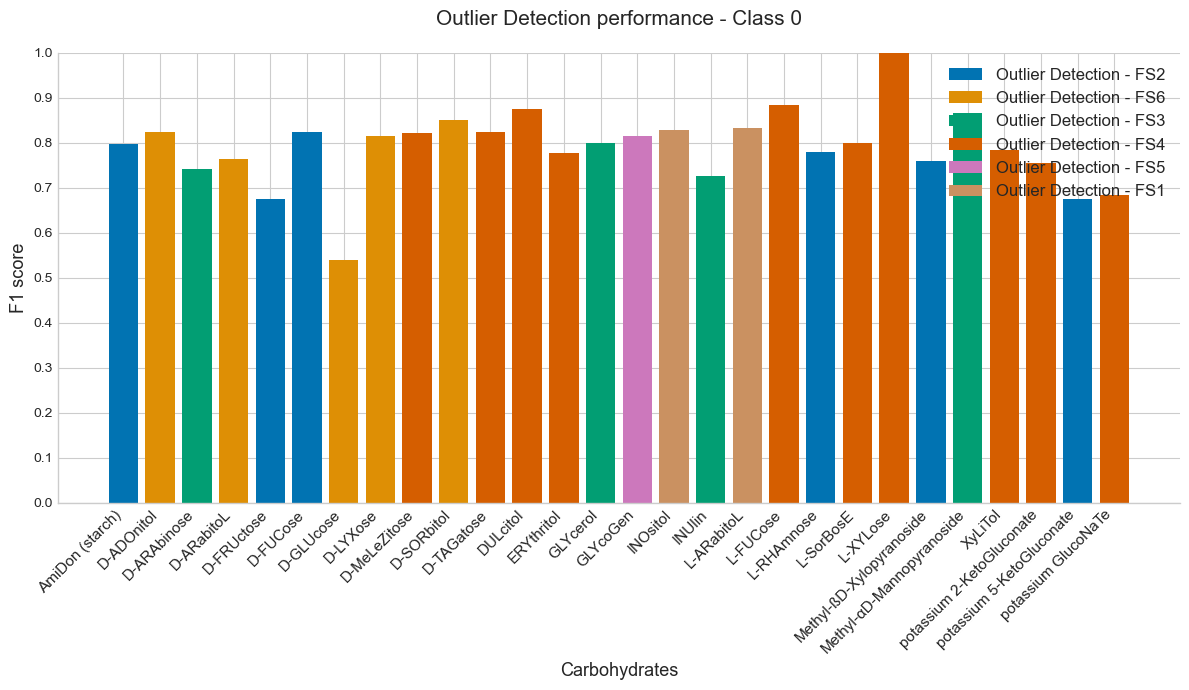

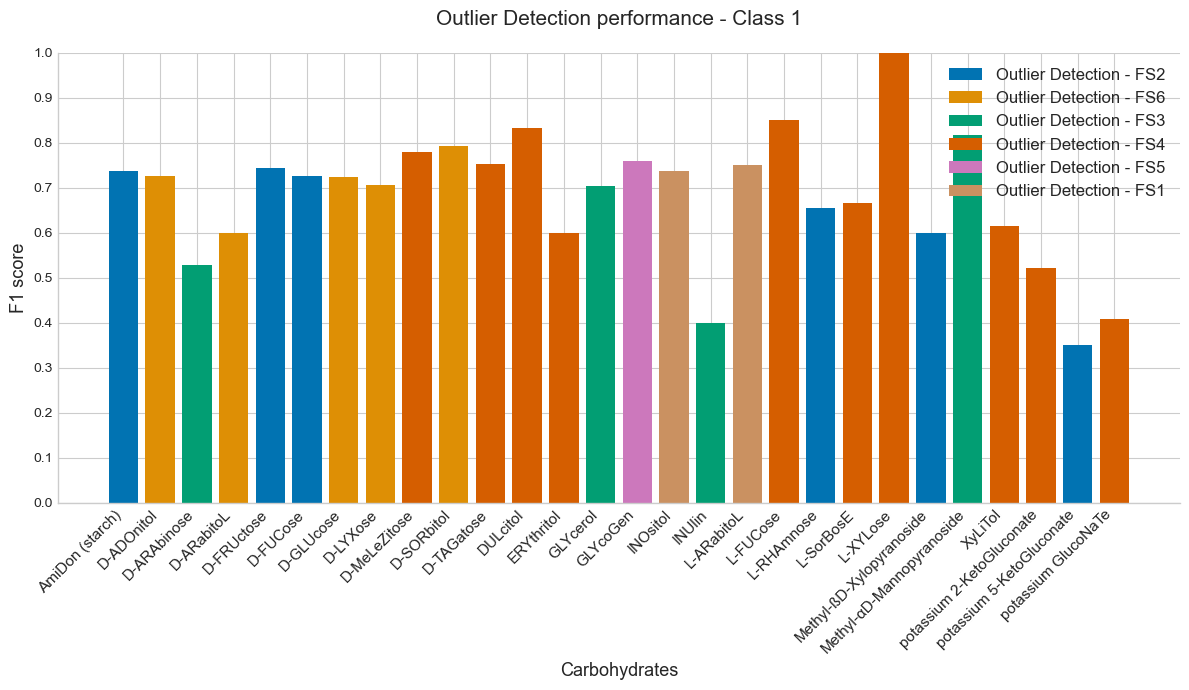

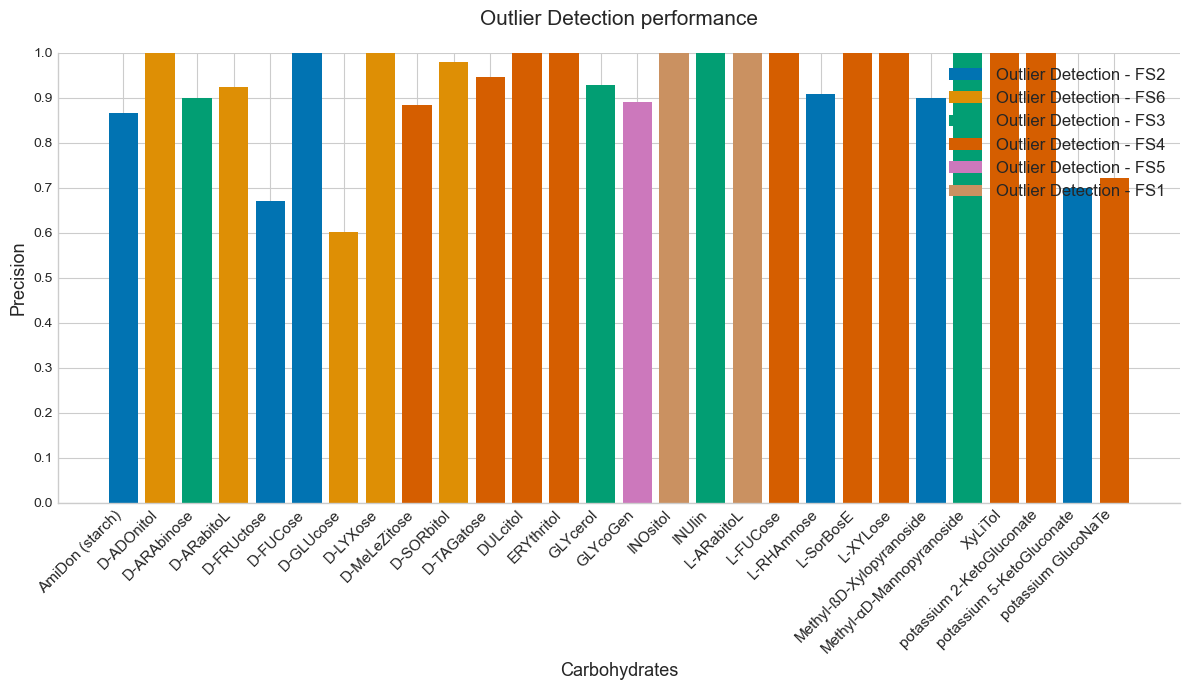

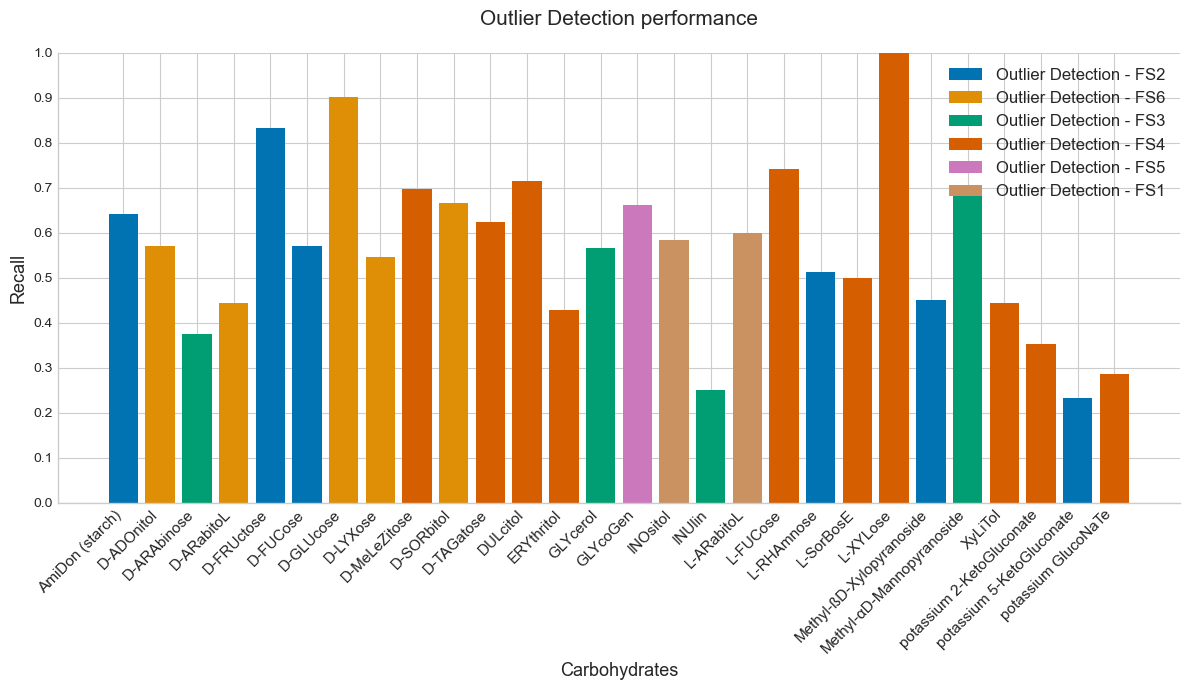

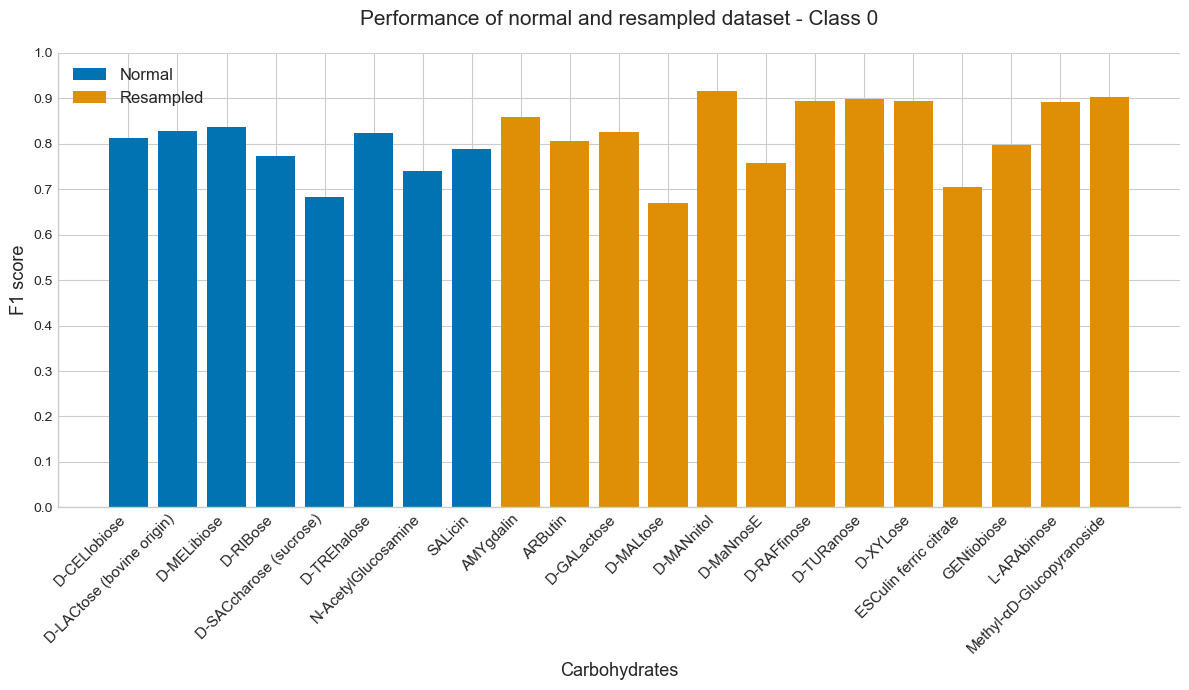

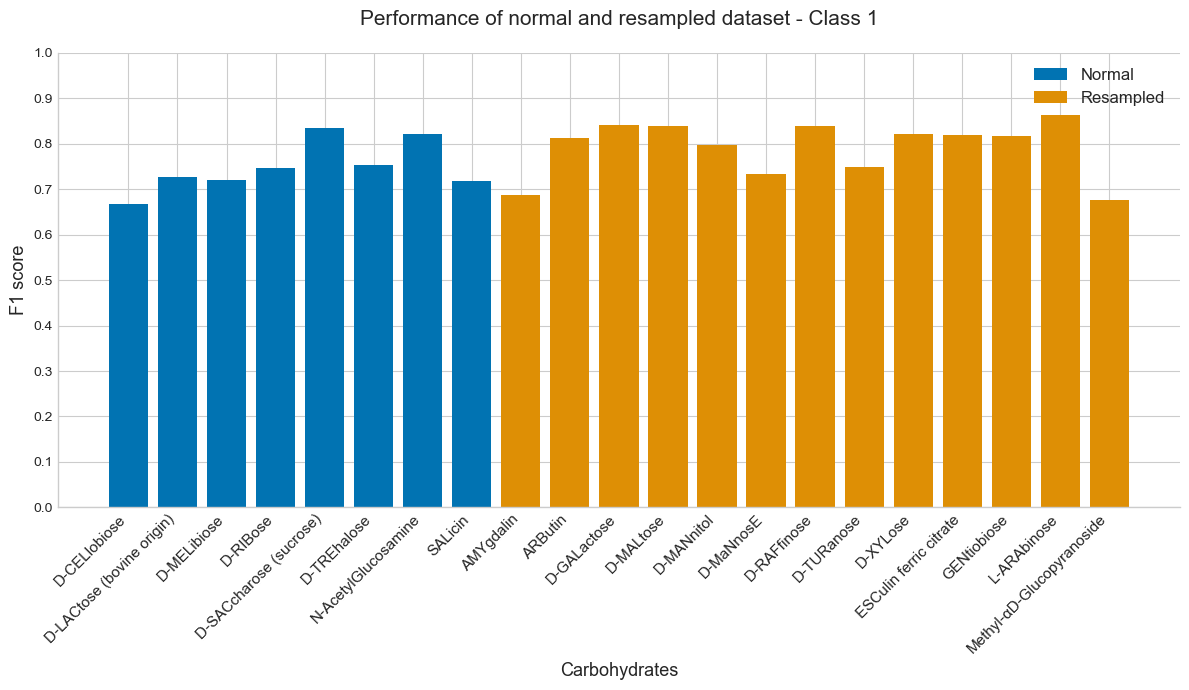

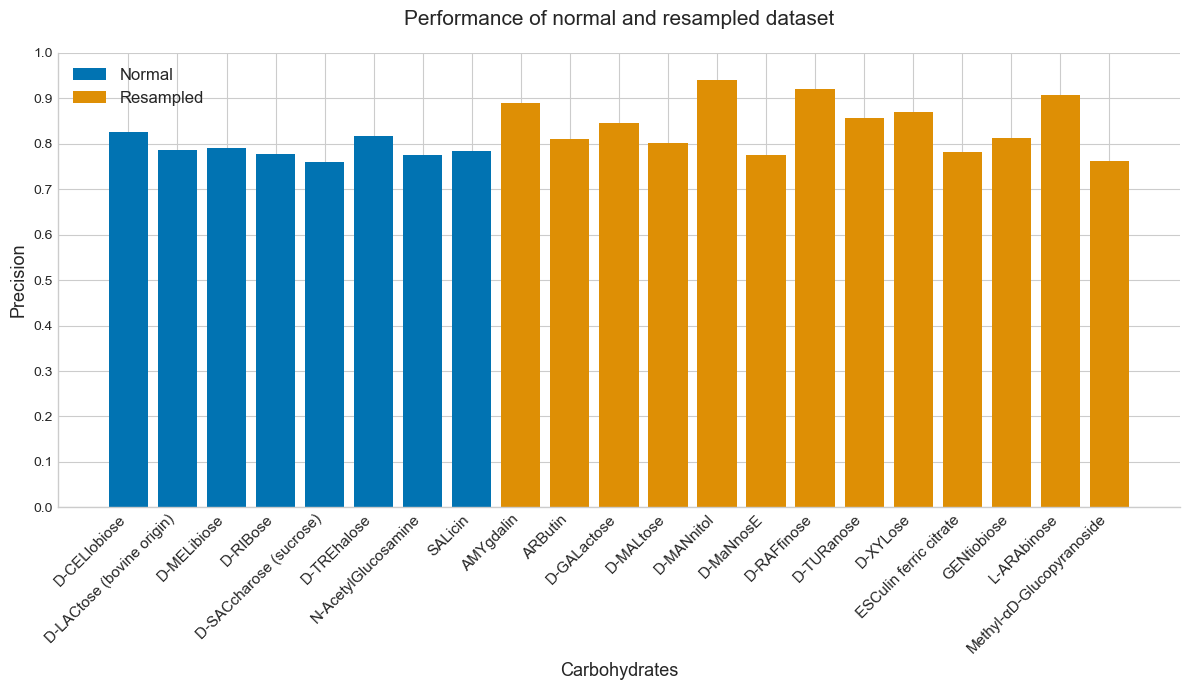

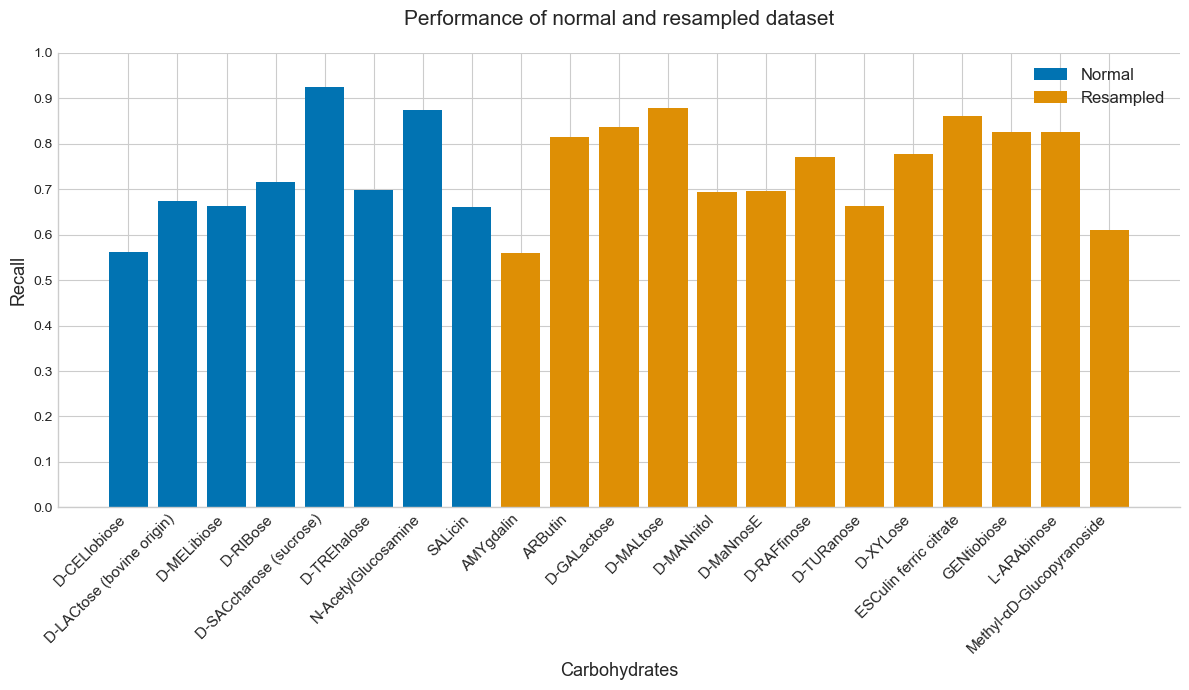

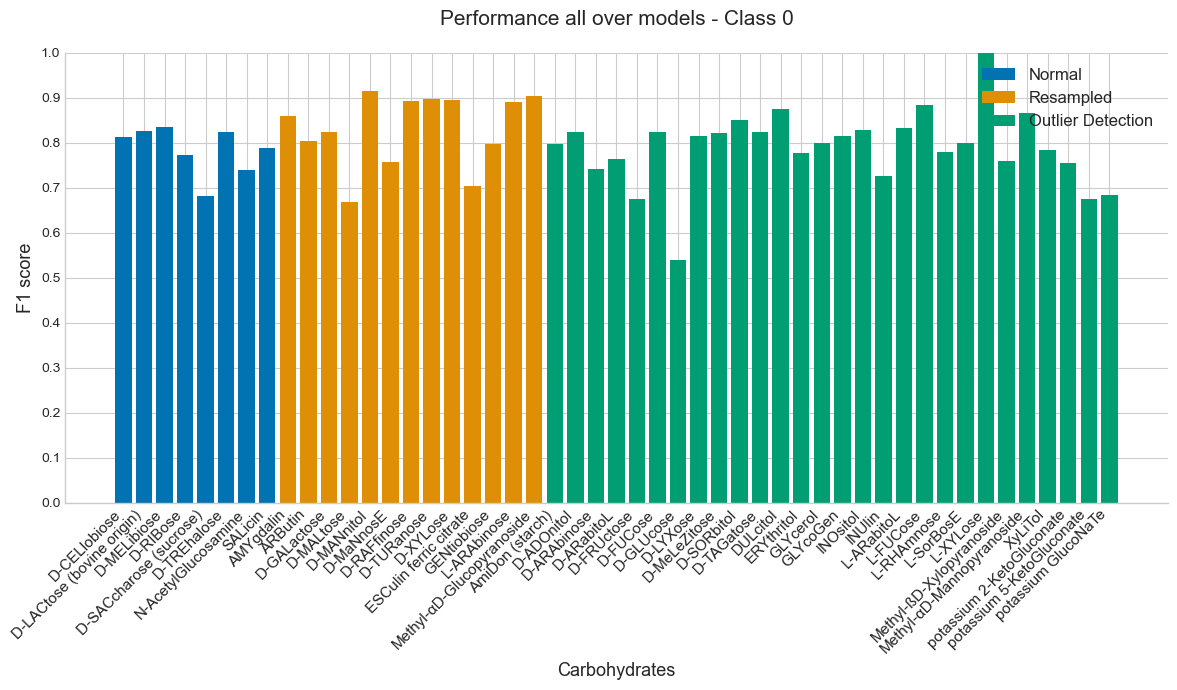

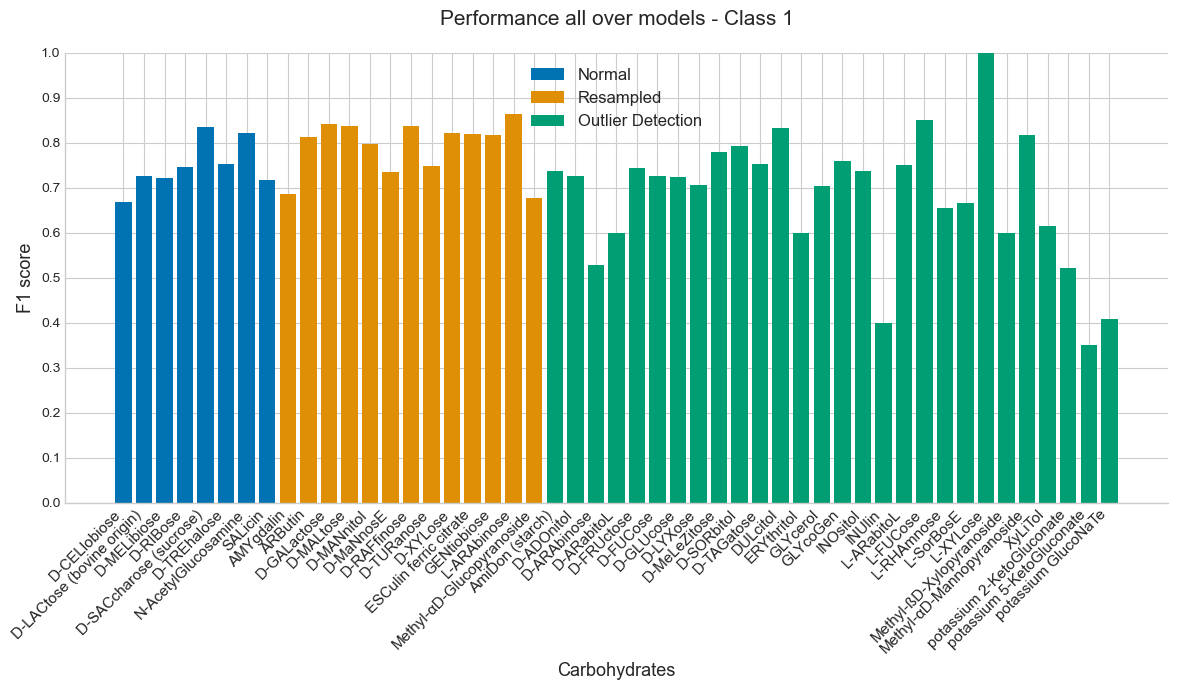

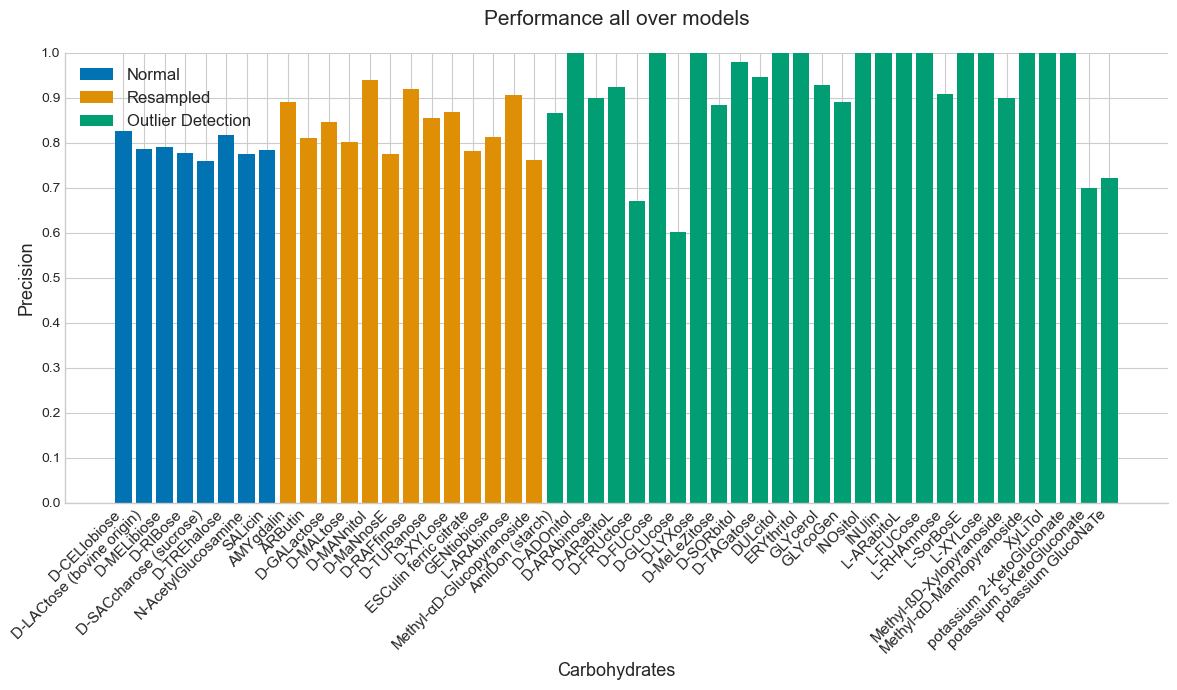

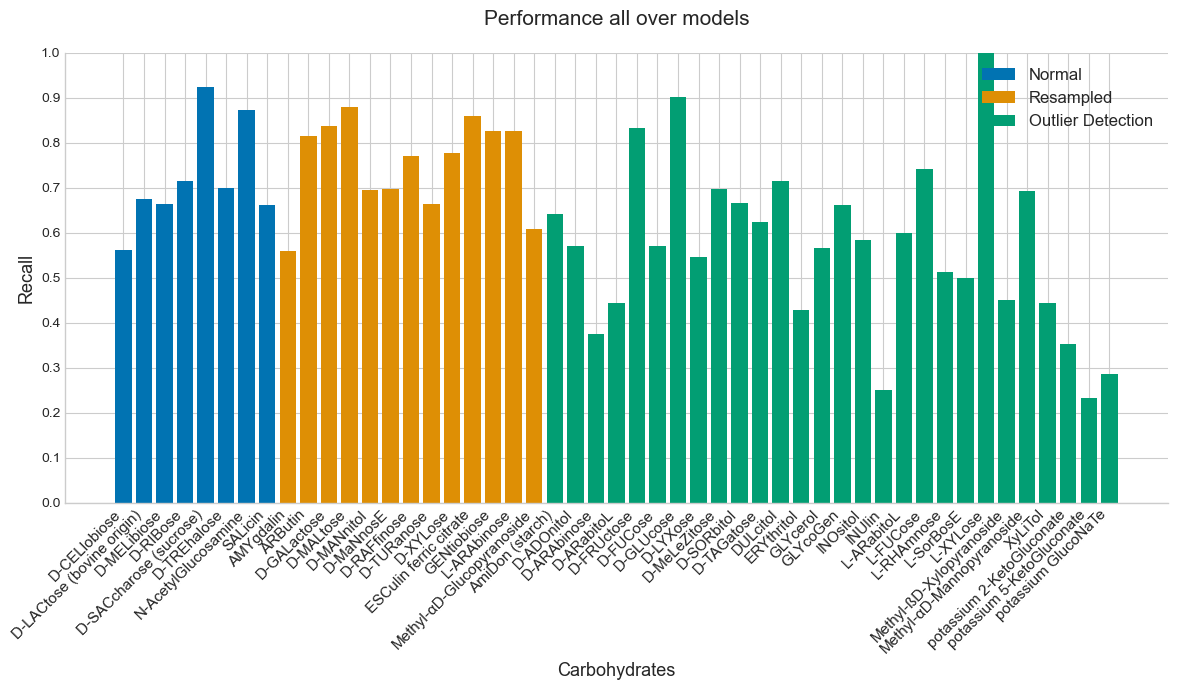

In [91]:
performance_classic = None
performance_resampled = None
od_1 = None
od_2 = None 
od_3 = None

if os.path.exists('./Result/Performance/performance_classic.xlsx'):
    performance_classic = pd.read_excel('./Result/Performance/performance_classic.xlsx').set_index('Carbohydrates')

if os.path.exists('./Result/Performance/performance_resampled.xlsx'):
    performance_resampled = pd.read_excel('./Result/Performance/performance_resampled.xlsx').set_index('Carbohydrates')

if os.path.exists('./Result/Performance/performance_OD1.xlsx'):
    od_1 = pd.read_excel('./Result/Performance/performance_OD1.xlsx').set_index('Carbohydrates')

if os.path.exists('./Result/Performance/performance_OD2.xlsx'):
    od_2 = pd.read_excel('./Result/Performance/performance_OD2.xlsx').set_index('Carbohydrates')
    
if os.path.exists('./Result/Performance/performance_OD3.xlsx'):
    od_3 = pd.read_excel('./Result/Performance/performance_OD3.xlsx').set_index('Carbohydrates')
    

performance_outlier_detection = pd.concat([od_1, od_2, od_3], axis=0)

# plot_performance(performance_outlier_detection.sort_index(), file_name='performance_OD_class_0', metric='F1 score class 0', title='Outlier Detection performance - Class 0')
plot_performance(performance_outlier_detection.sort_index(), file_name='performance_OD_class_1', metric='F1 score class 1', title='Outlier Detection performance - Class 1')
# plot_performance(performance_outlier_detection.sort_index(), file_name='performance_OD_precision', metric='Precision', title='Outlier Detection performance')
# plot_performance(performance_outlier_detection.sort_index(), file_name='performance_OD_recall', metric='Recall', title='Outlier Detection performance')

# plot_performance(pd.concat([performance_classic.sort_index(), performance_resampled.sort_index()], axis=0), file_name='performance_rf_class_0', metric='F1 score class 0', title='Performance of normal and resampled dataset - Class 0')
plot_performance(pd.concat([performance_classic.sort_index(), performance_resampled.sort_index()], axis=0), file_name='performance_rf_class_1', metric='F1 score class 1', title='Performance of normal and resampled dataset - Class 1')
# plot_performance(pd.concat([performance_classic.sort_index(), performance_resampled.sort_index()], axis=0), file_name='performance_rf_precision', metric='Precision', title='Performance of normal and resampled dataset')
# plot_performance(pd.concat([performance_classic.sort_index(), performance_resampled.sort_index()], axis=0), file_name='performance_rf_recall', metric='Recall', title='Performance of normal and resampled dataset')

performance_outlier_detection['Misc'] = 'Outlier Detection'
performance = pd.concat([performance_classic.sort_index(), performance_resampled.sort_index(), performance_outlier_detection.sort_index()], axis=0)

# plot_performance(performance, file_name='performance_class_0', metric='F1 score class 0', title='Performance all over models - Class 0')
plot_performance(performance, file_name='performance_class_1', metric='F1 score class 1', title='Performance all over models - Class 1')
# plot_performance(performance, file_name='performance_precision', metric='Precision', title='Performance all over models')
# plot_performance(performance, file_name='performance_recall', metric='Recall', title='Performance all over models')

with pd.ExcelWriter('./Result/Performance/performance_OD.xlsx') as writer:
    performance_outlier_detection.to_excel(writer, index=True)
    
with pd.ExcelWriter('./Result/Performance/performance.xlsx') as writer:
    performance.to_excel(writer, index=True)